# Problem Statement 

- Email spam, or junk mail, is a persistent issue that fills inboxes with unsolicited and potentially harmful content, including cryptic messages, scams, and phishing attempts. During an engaging data science internship at Oasis Infobyte, we aim to develop an effective email spam detection system using Python and machine learning.

- In today's digital age, addressing spam emails is increasingly urgent as they inundate inboxes with malicious content.

This dataset includes two columns:

- Category
- Message

# Objective of the case study

- To distinguish between Spam or Ham from the present datastet
- Identifying potential challenges in email spam detection, including evasive techniques used by spammers, and proposing avenues for future work and research in this domain.

# Methodology followed 

- Step 1 : Importing necessary warnings and libraries
- Step 2 : Reading and Cleaning the dataset
- Step 3 : Exploratory Data Analysis (EDA)
- Step 4 : Feature Engineering, Data Pre-Processing for Modelling
- Step 5 : Model Evaluation
- Step 5 : Recommendation/Conclusion

# Step 1 : Importing necessary warnings and libraries

In [13]:
!pip install wordcloud

In [17]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline


import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Step 2 : Reading and Cleaning the dataset

In [97]:
spam=pd.read_csv('spam.csv')
spam.head(2)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...


In [95]:
spam.shape

(5572, 2)

In [25]:
spam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [27]:
# Finding Duplicate Value Count, if any

dup = spam.duplicated().sum()
print(f'number of duplicated rows are {dup}')

number of duplicated rows are 415


In [29]:
# Checking for any missing values

spam.isnull().sum()

Category    0
Message     0
dtype: int64

In [31]:
spam.describe()

,Category,Message
count,5572,5572
unique,2,5157
top,ham,"Sorry, I'll call later"
freq,4825,30


In [39]:
# Create a binary 'Spam' column: 1 for 'spam' and 0 for 'ham', based on the 'Category' column.

spam['Spam'] = spam['Category'].apply(lambda x: 1 if x == 'spam' else 0)

In [41]:
#Rechecking the dataset 

spam.head(2)

,Category,Message,Spam
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0


- We can see that post creating the Spam column, it is easy to understand the distribution of spam and ham. Let us do some basic EDA and understand the dataset 

# Step 3 : Exploratory Data Analysis (EDA)

### - We can draw a basic pie chart to understand the distribution of Spam/Ham

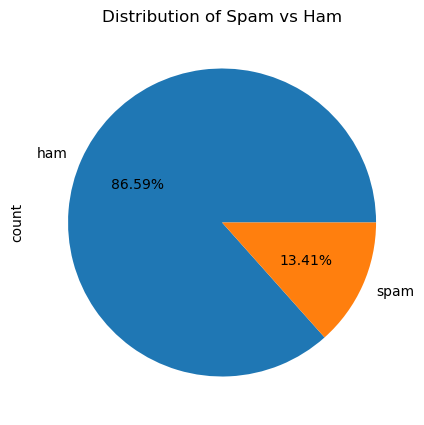

In [50]:
# Pie Chart Visualization for Spam vs Ham Distribution
spam['Category'].value_counts().plot(kind='pie', autopct='%1.2f%%', figsize=(5, 5), title='Distribution of Spam vs Ham')
plt.show()

- We can see that only 13.41% of emails are spam. So it does provide a quite an important insight. 

### - Let us understand the most used words in the spam category

In [54]:
# Splitting Spam Messages
spam_most = spam[spam['Category']=='spam'].copy()

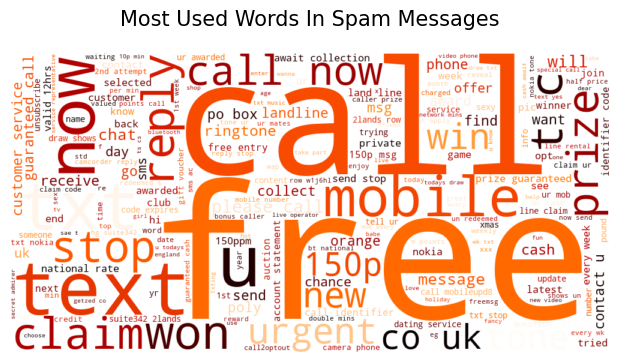

In [56]:
# Generate WordCloud for Spam Messages

comment_words = " ".join(str(msg).lower() for msg in spam_most.Message)

wordcloud = WordCloud(width=1000, height=500, background_color='white', stopwords=set(STOPWORDS),
                      min_font_size=10, max_words=1000, colormap='gist_heat_r').generate(comment_words)

# Plot WordCloud
plt.figure(figsize=(6, 6))
plt.title('Most Used Words In Spam Messages', fontsize=15, pad=20)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

# Step 4 : Feature Engineering, Data Pre-Processing for Modelling

In [60]:
# Splitting the data to train and test
X_train,X_test,y_train,y_test=train_test_split(spam.Message,spam.Spam,test_size=0.25)

In [80]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    """
    Evaluate a model on training and test sets, displaying metrics, ROC curves, and confusion matrices.
    Returns precision, recall, accuracy, ROC AUC, and F1 scores for train and test sets.
    """
    from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report, accuracy_score
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd

    # Fit the model and make predictions
    model.fit(X_train, y_train)
    results = {
        "train": {"y_pred": model.predict(X_train), "y_prob": model.predict_proba(X_train)[:, 1]},
        "test": {"y_pred": model.predict(X_test), "y_prob": model.predict_proba(X_test)[:, 1]}
    }

    # Metrics and Reports
    scores = {}
    for key, data in results.items():
        roc_auc = roc_auc_score(eval(f"y_{key}"), data["y_prob"])
        accuracy = accuracy_score(eval(f"y_{key}"), data["y_pred"])
        report = classification_report(eval(f"y_{key}"), data["y_pred"], output_dict=True)['weighted avg']
        scores[key] = {
            "roc_auc": roc_auc, "accuracy": accuracy,
            "precision": report['precision'], "recall": report['recall'], "f1_score": report['f1-score']
        }

    # ROC Curve Plot
    plt.figure(figsize=(6, 6))
    for key, data in results.items():
        fpr, tpr, _ = roc_curve(eval(f"y_{key}"), data["y_prob"])
        plt.plot(fpr, tpr, label=f"{key.capitalize()} ROC AUC: {scores[key]['roc_auc']:.2f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title("ROC Curve"); plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.legend(); plt.show()

    # Confusion Matrix Plot
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    for ax, key in zip(axes, results):
        cm = confusion_matrix(eval(f"y_{key}"), results[key]["y_pred"])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], ax=ax)
        ax.set_title(f"{key.capitalize()} Confusion Matrix")
        ax.set_xlabel("Predicted"); ax.set_ylabel("Actual")
    plt.tight_layout(); plt.show()

    return scores


### - Naive Bayes Modelling

In [83]:
# ML Model - 1 Implementation
# Create a machine learning pipeline using scikit-learn, combining text vectorization (CountVectorizer)
# and a Multinomial Naive Bayes classifier for email spam detection.
clf = Pipeline([
    ('vectorizer', CountVectorizer()),  # Step 1: Text data transformation
    ('nb', MultinomialNB())  # Step 2: Classification using Naive Bayes
])

# Model is trained (fit) and predicted in the evaluate model

# Step 5 : Model Evaluation

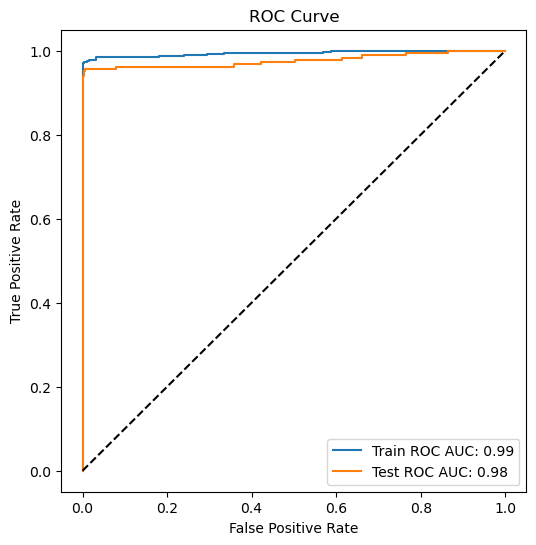

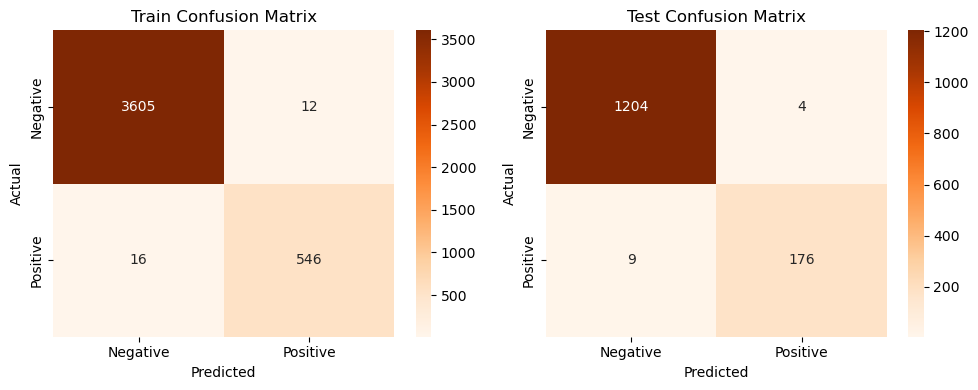

In [86]:
# Visualizing evaluation Metric Score chart
MultinomialNB_score = evaluate_model(clf, X_train, X_test, y_train, y_test)

INSIGHTS - 

- High Predictive Performance:
The ROC AUC values for both the train (0.99) and test (0.98) datasets are very close to 1, indicating that the model has excellent discriminatory power in distinguishing between positive and negative classes.

- Consistency Between Train and Test Performance:
The train and test curves are closely aligned, with only a slight gap between them. This suggests the model generalizes well and is not overfitting to the training data.

- Model Reliability:
The curve's steep rise toward the top-left corner shows the model achieves high true positive rates (sensitivity) with low false positive rates, making it reliable for predicting positive cases.

INSIGHTS - 

- High True Positives (TP) and True Negatives (TN):
The model performs exceptionally well in both training and testing datasets, as reflected in the large number of true positives (546 for test, 3605 for train) and true negatives (1204 for test, 3605 for train). This indicates that the model is correctly identifying most of the negative and positive cases.


- Low False Positives (FP) and False Negatives (FN):
There are relatively few false positives (12 for train, 4 for test) and false negatives (16 for train, 9 for test). This means the model is not misclassifying many samples, whether positive or negative, further suggesting good performance.



- Good Generalization:

The confusion matrices for the train and test sets are very similar, indicating that the model generalizes well to unseen data. The performance on the test set is almost as good as the performance on the training set, which suggests that the model has not overfitted.

# Step 6 : Recommendation/Conclusion

In [91]:
# Defining a function for the Email Spam Detection System
def detect_spam(email_text):
    # Load the trained classifier (clf) here
    # Replace the comment with your code to load the classifier model

    # Make a prediction using the loaded classifier
    prediction = clf.predict([email_text])

    if prediction == 0:
        return "This is a Ham Email!"
    else:
        return "This is a Spam Email!"


In [102]:
# Example of how to use the function
sample_email = 'I HAVE A DATE ON SUNDAY WITH WILL!!'
result = detect_spam(sample_email)
print(result)

This is a Ham Email!


- So we have built a simple function to understand the spam/ham email

### Final Takeaway

Key Insights:

- Our dataset revealed that approximately 13.41% of messages were classified as spam, while 86.59% were categorized as ham. This distribution was a critical foundation for our analysis.

- During the exploratory data analysis (EDA), we identified common spam keywords such as 'free,' 'call,' 'text,' 'txt,' and 'now.' These terms often trigger spam filters and were key features for our machine learning model.

- In our machine learning efforts, the Multinomial Naive Bayes model stood out, achieving an impressive 98.49% accuracy on the recall test set. This result highlights the model's effectiveness in accurately identifying and filtering spam emails, enhancing email security and user experience.